In this notebook, we perform harmonization of the lymph node data with the totalVI data, perform quality control, check for doublets, as well as annotation. Refer to the other notebook for analysis

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import os
import scipy.io
import seaborn as sb
import anndata

import torch
import scvi
from scvi.model import SCVI, SCANVI

import scrublet as scr

import matplotlib.pyplot as plt
%matplotlib inline

save_path = "/home/ubuntu/mouse_lymph_node/nova/"

/home/ubuntu/anaconda3/envs/spatialVI/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatialVI/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatialVI/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


### Load nova-seq run

In [2]:
a1 = sc.read_10x_h5(save_path + "LN_MS-1/filtered_feature_bc_matrix.h5")
a1.var_names_make_unique()

a2 = sc.read_10x_h5(save_path + "LN_MS-2/filtered_feature_bc_matrix.h5")
a2.var_names_make_unique()

a3 = sc.read_10x_h5(save_path + "LN_PBS-1/filtered_feature_bc_matrix.h5")
a3.var_names_make_unique()

a4 = sc.read_10x_h5(save_path + "LN_PBS-2/filtered_feature_bc_matrix.h5")
a4.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Load data from TotalVI paper

In [3]:
sln111 = sc.read_h5ad("../totalVI_data/spleen_lymph_111.h5ad")
sln206 = sc.read_h5ad("../totalVI_data/spleen_lymph_206.h5ad")
# take lymph node and spleen
sln111_ln = sln111[sln111.obs["seurat_hash_id"] == "Lymph_Node"]
sln206_ln = sln206[sln206.obs["seurat_hash_id"] == "Lymph_Node"]
sln111_spleen = sln111[sln111.obs["seurat_hash_id"] == "Spleen"]
sln206_spleen = sln206[sln206.obs["seurat_hash_id"] == "Spleen"]

### Merge them into one AnnData file

In [20]:
adata = a1.concatenate(a2, a3, a4, sln111_ln, sln111_spleen, sln206_ln, sln206_spleen, batch_key='batch')

In [21]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [22]:
adata.var['mt'] = adata.var_names.str.startswith('mt')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.var["highly_variable"] = adata.var["highly_variable-4"]

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'seurat_hash_id' as categorical
... storing 'hash_id' as categorical
... storing 'leiden_subclusters' as categorical
... storing 'cell_types' as categorical
... storing 'feature_types' as categorical
... storing 'genome-0' as categorical
... storing 'genome-1' as categorical
... storing 'genome-2' as categorical
... storing 'genome-3' as categorical


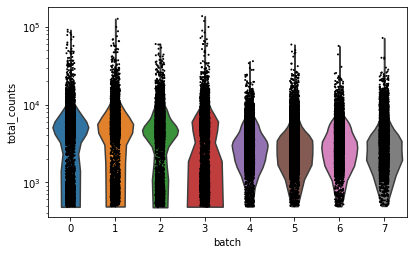

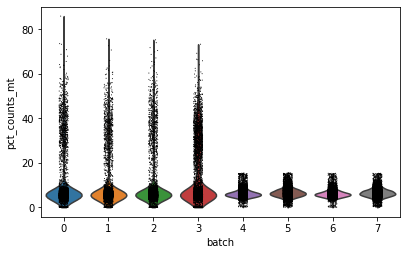

In [23]:
sc.pl.violin(adata, 'total_counts', groupby='batch', size=2, log=True, cut=0)
sc.pl.violin(adata, 'pct_counts_mt', groupby='batch')

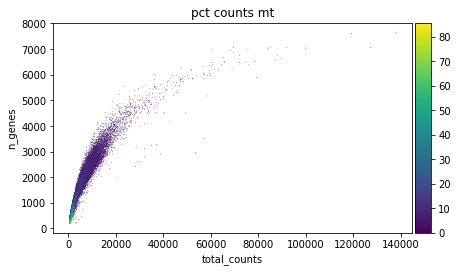

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


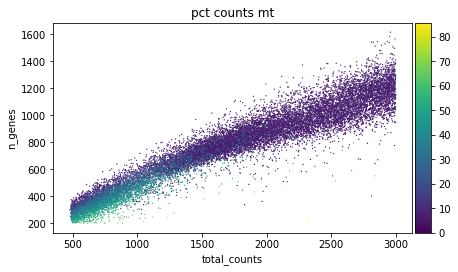

In [24]:
#Data quality summary plots; 
sc.pl.scatter(adata, 'total_counts', 'n_genes', color='pct_counts_mt')
sc.pl.scatter(adata[adata.obs['total_counts']<3000], 'total_counts', 'n_genes', color='pct_counts_mt')

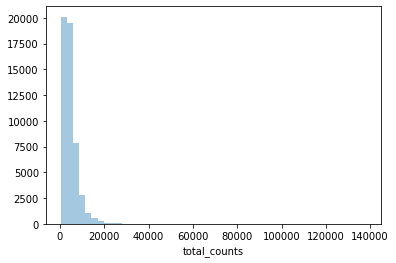

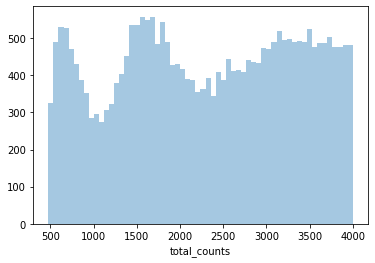

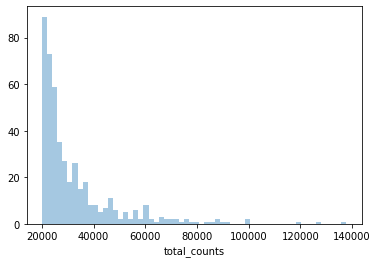

In [25]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['total_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata.obs['total_counts'][adata.obs['total_counts']<4000], kde=False, bins=60)
plt.show()

p5 = sb.distplot(adata.obs['total_counts'][adata.obs['total_counts']>20000], kde=False, bins=60)
plt.show()

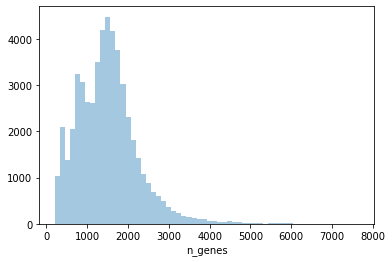

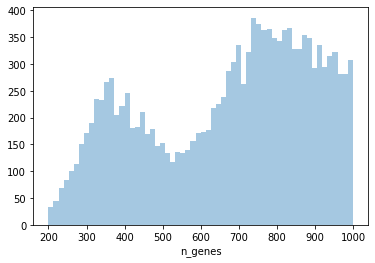

In [26]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
plt.show()

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


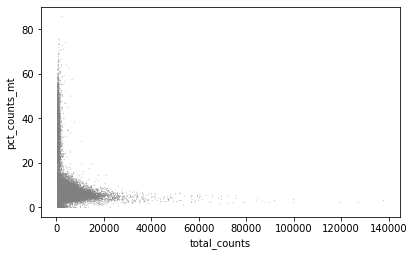

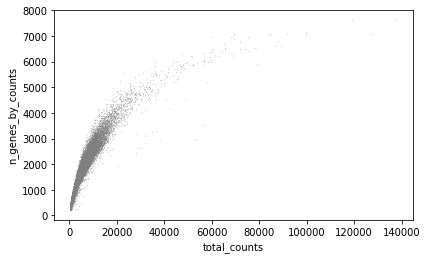

In [27]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [28]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1250)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 60000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['pct_counts_mt'] < 20]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

Total number of cells: 52622


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Number of cells after min count filter: 47566
Number of cells after max count filter: 47534
Number of cells after MT filter: 46942


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [29]:
# clean adata
del adata.obs["n_protein_counts"]
del adata.obs["n_proteins"]
del adata.obs["seurat_hash_id"]
del adata.obs["batch_indices"]
del adata.obs["percent_mito"]
del adata.obs["leiden_subclusters"]
del adata.obs["hash_id"]
del adata.obs["n_counts"]

In [30]:
# clean gene attributes
del adata.var["feature_types"]
del adata.var["gene_ids-1"]
del adata.var["genome-1"]
del adata.var["gene_ids-2"]
del adata.var["genome-2"]
del adata.var["gene_ids-3"]
del adata.var["genome-3"]
del adata.var["gene_ids-4"]
del adata.var["gene_ids-5"]
del adata.var["gene_ids-6"]
del adata.var["gene_ids-7"]
del adata.var["highly_variable-4"]
del adata.var["highly_variable_mean_variance-4"]
del adata.var["encode-4"]
del adata.var["hvg_encode-4"]
del adata.var["highly_variable-5"]
del adata.var["highly_variable_mean_variance-5"]
del adata.var["encode-5"]
del adata.var["hvg_encode-5"]
del adata.var["highly_variable-6"]
del adata.var["highly_variable_mean_variance-6"]
del adata.var["encode-6"]
del adata.var["hvg_encode-6"]
del adata.var["highly_variable-7"]
del adata.var["highly_variable_mean_variance-7"]
del adata.var["encode-7"]
del adata.var["hvg_encode-7"]

In [31]:
adata.obs

,n_genes,cell_types,batch,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCCAAGCAGAAAG-1-0,1505,nan,0,1505,5862.0,307.0,5.237121
AAACCCAAGGTCACAG-1-0,1883,nan,0,1883,6673.0,346.0,5.185074
AAACCCACATCGTTCC-1-0,2080,nan,0,2080,7764.0,438.0,5.641422
AAACCCAGTCGTCTCT-1-0,1647,nan,0,1647,4619.0,265.0,5.737173
AAACCCAGTGTAAACA-1-0,1857,nan,0,1857,5965.0,339.0,5.683152
...,...,...,...,...,...,...,...
TTTGTTGGTAGAGGAA-2-7,757,Ifit3-high B,7,757,1535.0,115.0,7.491857
TTTGTTGGTCCAGCGT-2-7,628,Ifit3-high B,7,628,1299.0,94.0,7.236335
TTTGTTGGTGGGCTCT-2-7,757,Mature B,7,757,1535.0,167.0,10.879478
TTTGTTGTCACGAGGA-2-7,724,CD4 T,7,724,1376.0,99.0,7.194767


In [32]:
adata.var

,gene_ids-0,genome-0,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable
Mrpl15,ENSMUSG00000033845,mm10,12710,False,12710,0.324807,75.846604,17092.0,False
Lypla1,ENSMUSG00000025903,mm10,7830,False,7830,0.178690,85.120292,9403.0,False
Tcea1,ENSMUSG00000033813,mm10,16971,False,16971,0.466497,67.749230,24548.0,False
Atp6v1h,ENSMUSG00000033793,mm10,9174,False,9174,0.214112,82.566227,11267.0,False
Rb1cc1,ENSMUSG00000025907,mm10,15156,False,15156,0.395861,71.198358,20831.0,False
...,...,...,...,...,...,...,...,...,...
Csprs,ENSMUSG00000062783,mm10,1573,False,1573,0.035479,97.010756,1867.0,False
AC132444.6,ENSMUSG00000096808,mm10,115,False,115,0.002261,99.781460,119.0,False
Vamp7,ENSMUSG00000051412,mm10,3430,False,3430,0.074665,93.481814,3929.0,False
Tmlhe,ENSMUSG00000079834,mm10,381,False,381,0.007373,99.275968,388.0,False


### Extract AnnData for Scrublet and scVI

In [33]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

In [35]:
adata_filt = adata[:, adata.var.highly_variable].copy()

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [36]:
adata_filt

AnnData object with n_obs × n_vars = 46942 × 3876
    obs: 'n_genes', 'cell_types', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids-0', 'genome-0', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable'
    uns: 'batch_colors', 'log1p'
    layers: 'counts'

### look for doublets

In [42]:
X = adata_filt.layers["counts"].A
batch_indices = adata_filt.obs["batch"]

doublet_scores = np.zeros(shape=(X.shape[0]))
doublet_predictions = np.zeros(shape=(X.shape[0]))
# run scrublet separately on every batch; should take a couple of seconds
for b in np.unique(batch_indices.values):
    mask = batch_indices.values == b
    scores, predictions = scr.Scrublet(X[mask]).scrub_doublets()
    doublet_scores[mask] = scores
    doublet_predictions[mask] = predictions

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


/home/ubuntu/anaconda3/envs/spatialVI/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Automatically set threshold at doublet score = 0.41
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 38.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.0%
Elapsed time: 3.1 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.38
Detected doublet rate = 2.0%
Estimated detectable doublet fraction = 40.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.9%
Elapsed time: 2.5 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 1.9%
Estimated detectable doublet fraction = 40.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.7%
Elapsed time: 3.6 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at dou

In [44]:
adata.obs["doublets_scores"] = doublet_scores
adata.obs["doublets_predictions"] = doublet_predictions

### pass through scVI

In [97]:
scvi.data.setup_anndata(adata_filt, layer="counts", batch_key="batch")

INFO      Using batches from adata.obs["batch"]                                 
INFO      No label_key inputted, assuming all cells have same label             
INFO      Using data from adata.layers["counts"]                                
INFO      Computing library size prior per batch                                


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/ub

INFO      Successfully registered anndata object containing 46942 cells, 3876   
          genes, 8 batches, 1 labels, and 0 proteins. Also registered 0 extra   
          categorical covariates and 0 extra continuous covariates.             
INFO      Please do not further modify adata until model is trained.            


In [98]:
vae = scvi.model.SCVI(adata_filt, n_latent=30, n_layers=2, gene_likelihood="nb")

In [99]:
train=False
if train:
    vae.train(frequency=5)
    plt.plot(vae.history["elbo_train_set"][1:], label="train")
    plt.plot(vae.history["elbo_test_set"][1:], label="test")
    plt.title("loss over training epochs")
    plt.legend()
    plt.show()
    vae.save("joint_LN_scvi/", overwrite=True)
else:
    vae = scvi.model.SCVI.load("joint_LN_scvi/", adata_filt, use_cuda=True)


INFO      Using data from adata.layers["counts"]                                
INFO      Computing library size prior per batch                                


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/ub

INFO      Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 
          'labels']                                                             
INFO      Successfully registered anndata object containing 46942 cells, 3876   
          genes, 8 batches, 1 labels, and 0 proteins. Also registered 0 extra   
          categorical covariates and 0 extra continuous covariates.             


In [57]:
# save latent space to anndata
adata.obsm["X_scVI"] = vae.get_latent_representation()

In [58]:
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(adata, min_dist=0.1)

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


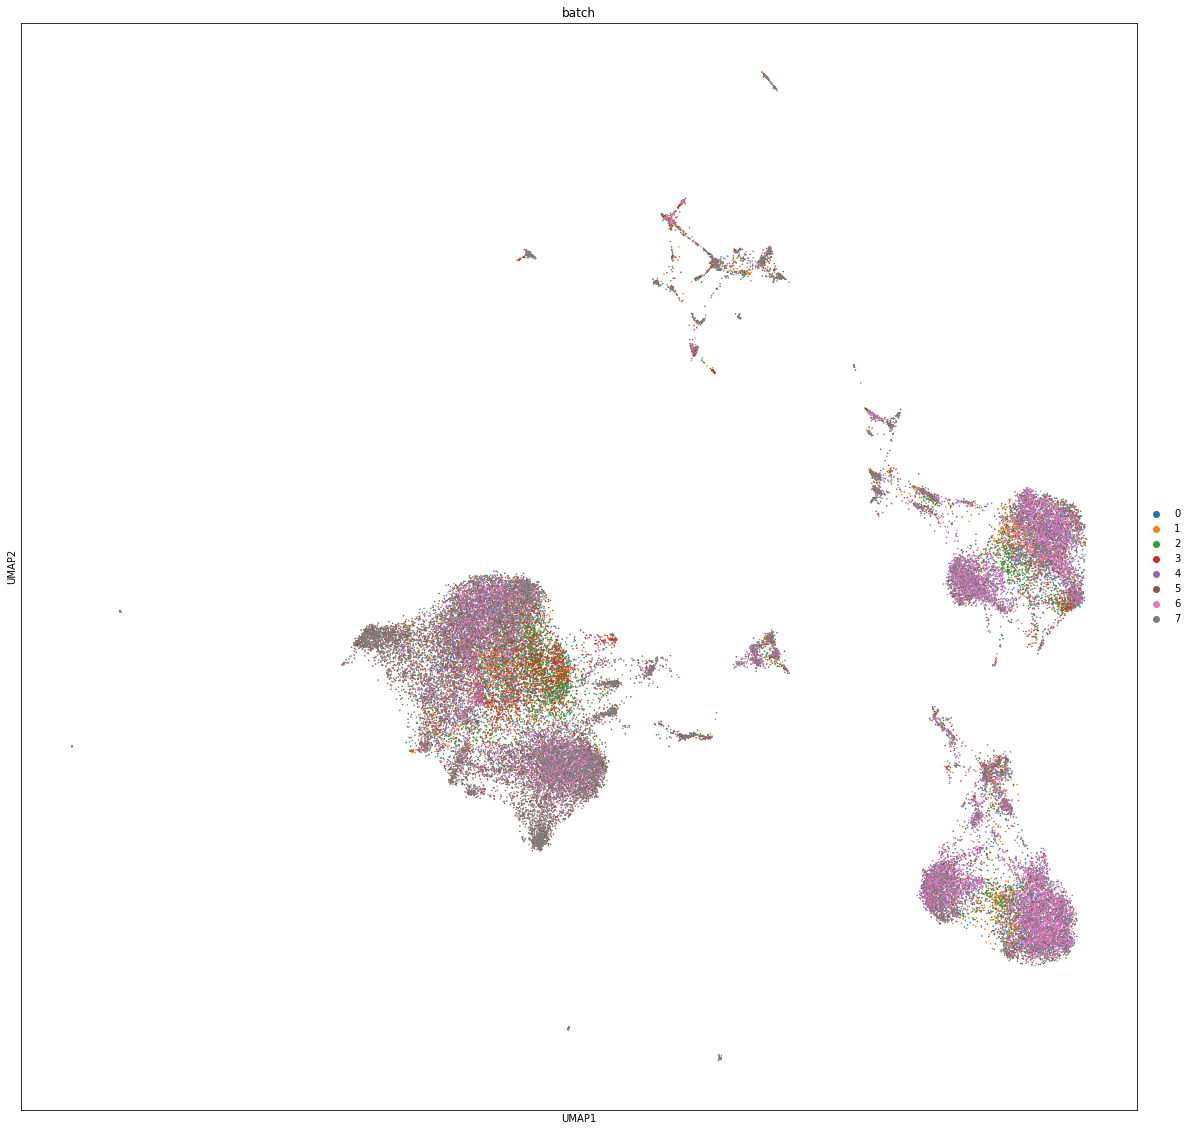

In [59]:
fig, ax = plt.subplots(figsize=(20, 20))
sc.pl.umap(adata, color=["batch"], size=10, ax=ax)

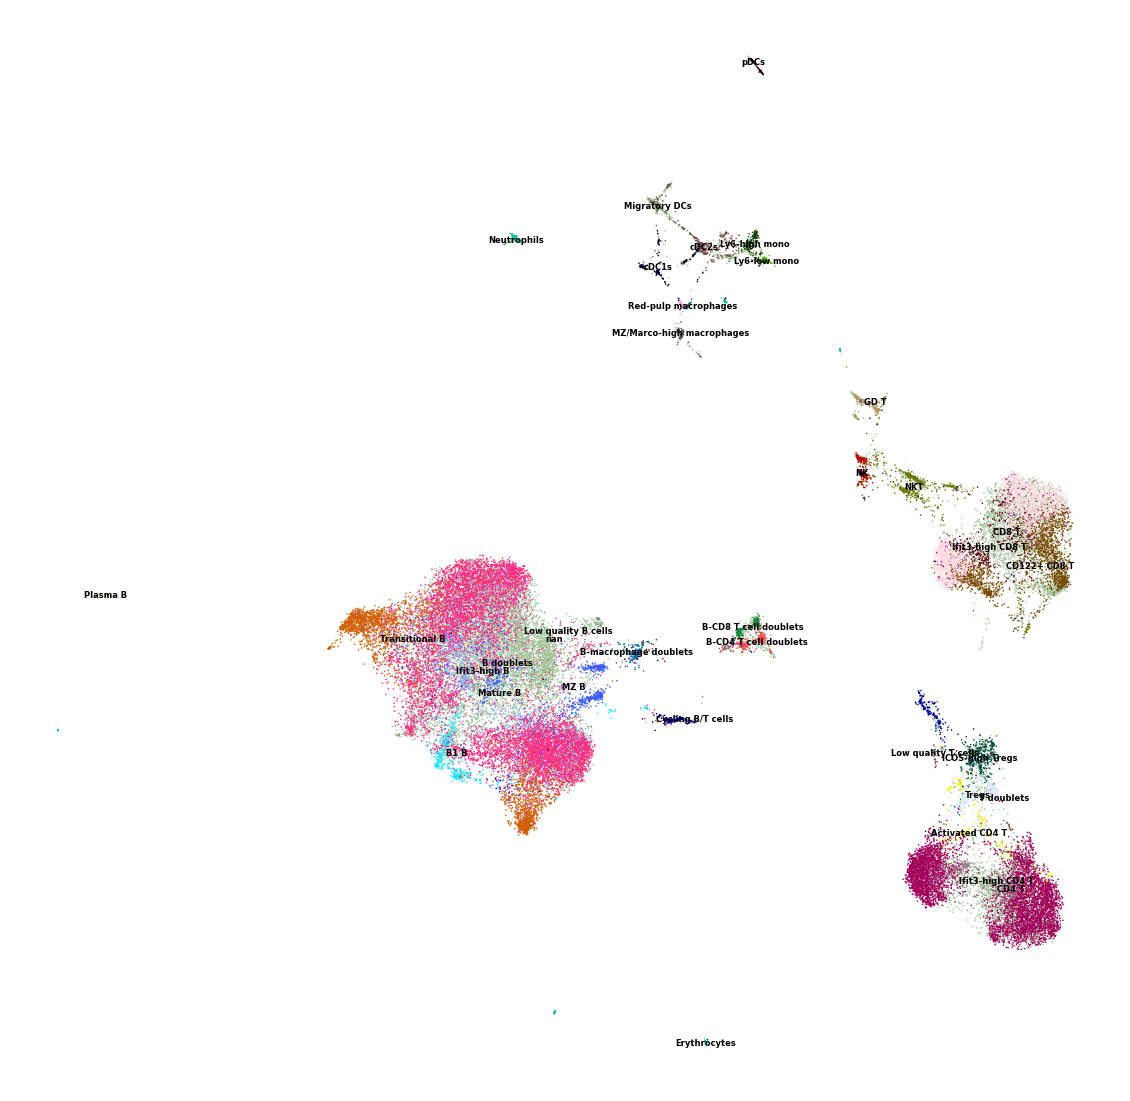

In [60]:
fig, ax = plt.subplots(figsize=(20, 20))
sc.pl.umap(
    adata, 
    color="cell_types",
    frameon=False,
    title="",
    legend_loc="on data",
    legend_fontsize="small",
    ax=ax, size=10
)

### transfer annotation with scANVI

In [100]:
# create balanced cell type labels
labels = np.array(["Unknown"] * adata.n_obs).astype("<U43")
for x in np.unique(adata.obs["cell_types"]):
    if x != "nan":
        idx = np.where(adata.obs["cell_types"] == x)[0]
        if len(idx) > 25:
            sampled = np.random.choice(idx, np.min([100, len(idx)]))
            labels[sampled] = x

adata_filt.obs["celltype_scanvi"] = labels

In [101]:
adata_filt.obs["celltype_scanvi"].value_counts()

Unknown                      44262
Mature B                       100
CD8 T                           99
Transitional B                  99
CD4 T                           98
Ifit3-high B                    97
Ifit3-high CD4 T                95
CD122+ CD8 T                    95
B doublets                      93
MZ B                            93
Ifit3-high CD8 T                91
B1 B                            91
NK                              89
ICOS-high Tregs                 89
B-CD4 T cell doublets           88
B-macrophage doublets           88
NKT                             87
Neutrophils                     87
Tregs                           87
Cycling B/T cells               87
GD T                            86
T doublets                      86
cDC2s                           83
B-CD8 T cell doublets           78
cDC1s                           78
Ly6-high mono                   77
Migratory DCs                   74
Activated CD4 T                 70
Ly6-low mono        

In [102]:
scvi.data.setup_anndata(
    adata_filt,
    layer="counts",
    batch_key="batch",
    labels_key="celltype_scanvi",
)

INFO      Using batches from adata.obs["batch"]                                 
INFO      Using labels from adata.obs["celltype_scanvi"]                        
INFO      Using data from adata.layers["counts"]                                
INFO      Computing library size prior per batch                                


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/ub

INFO      Successfully registered anndata object containing 46942 cells, 3876   
          genes, 8 batches, 34 labels, and 0 proteins. Also registered 0 extra  
          categorical covariates and 0 extra continuous covariates.             
INFO      Please do not further modify adata until model is trained.            


In [105]:
# use scvi to initialize scanvi
lvae = scvi.model.SCANVI(adata_filt, "Unknown", use_cuda=True, n_latent=30, n_layers=2)

In [106]:
train=False
if train:
    lvae.train(n_epochs_semisupervised=10)
    lvae.save("joint_LN_scanvi/", overwrite=True)
else:
    lvae = scvi.model.SCANVI.load("joint_LN_scanvi/", adata_filt, use_cuda=True)

INFO      Training for 170 epochs                                               
INFO      KL warmup phase exceeds overall training phaseIf your applications    
          rely on the posterior quality, consider training for more epochs or   
          reducing the kl warmup.                                               
INFO      KL warmup for 400 epochs                                              


Output()

INFO      Training is still in warming up phase. If your applications rely on   
          the posterior quality, consider training for more epochs or reducing  
          the kl warmup.                                                        
INFO      Training time:  1033 s. / 170 epochs                                  
INFO      Training for 10 epochs                                                
INFO      KL warmup phase exceeds overall training phaseIf your applications    
          rely on the posterior quality, consider training for more epochs or   
          reducing the kl warmup.                                               
INFO      KL warmup for 400 epochs                                              


Output()

INFO      Training for 1 epochs                                                 
INFO      Training for 1 epochs                                                 
INFO      Training for 1 epochs                                                 
INFO      Training for 1 epochs                                                 
INFO      Training for 1 epochs                                                 
INFO      Training for 1 epochs                                                 
INFO      Training for 1 epochs                                                 
INFO      Training for 1 epochs                                                 
INFO      Training for 1 epochs                                                 
INFO      Training for 1 epochs                                                 
INFO      Training is still in warming up phase. If your applications rely on   
          the posterior quality, consider training for more epochs or reducing  
          the kl warmup.    

In [107]:
adata.obs["SCANVI_pred_cell_types"] = lvae.predict(adata_filt)
adata.obs["MS"] = np.logical_or(adata.obs["batch"] == "0", adata.obs["batch"] == "1")

### also impute cell types with scVI + kNN for reference

In [110]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)

mask = adata.obs["cell_types"] != 'nan'
X, y = adata.obsm["X_scVI"][mask], adata.obs["cell_types"][mask]
neigh.fit(X, y)
adata.obs["SCVI_pred_cell_types"] = neigh.predict(adata.obsm["X_scVI"])

In [111]:
sc.write("harmonized_total_VI_and_nova_run.h5ad", adata)

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'SCANVI_pred_cell_types' as categorical
... storing 'SCVI_pred_cell_types' as categorical
